In [1]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras import utils
from sklearn.preprocessing import LabelEncoder
import matplotlib.patches as mpatches


In [2]:
# dir_path points towards where to find the image dataset
dir_path = "brain_tumor_dataset"
IMAGE_SHAPE = (224, 224)
MUBA_ITERS = 20

random_sample = 1

# Read the folders folders
directories = os.listdir(dir_path)

files = [] 
labels = []

# Read files for each directory
for folder in directories:
    
    fileList = glob.glob(f'{dir_path}/{folder}/*')
    labels.extend([folder for _ in fileList])
    files.extend(fileList)

len(files), len(labels)

(253, 253)

In [3]:
# At this point "no" is [1,0] and "yes" is [0,1]
yes_count = 0
for val in labels:
    if val == "yes":
        yes_count += 1
print(yes_count)

155


In [4]:
# One hot encoding

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y,dtype ="uint8", num_classes = 2)

labels = np.array(dummy_y)

print(f"Classes are {encoder.classes_}")

Classes are ['no' 'yes']


In [5]:
# Split the data into testing, training and validation data
# As using a random sample = 100, the testing set is the same as used for the model.
x_train, x_tv, y_train, y_tv = train_test_split(files, labels, test_size=.3, random_state = random_sample)
x_test, x_val, y_test, y_val = train_test_split(x_tv, y_tv, test_size=.5, random_state = random_sample)

In [6]:
images = []
labels = []

print("Preparing testing data")
for file, label in zip(x_test, y_test):

    # Prepare the image
    new_file = image.load_img(file, target_size=IMAGE_SHAPE)
    img_array = image.img_to_array(new_file)
    # Append to array
    images.append(img_array)
    labels.append(label)

Preparing testing data


In [7]:
# At this point "no" is [1,0] and "yes" is [0,1]
yes_count = 0
for val in labels:
    if val[1] == 1:
        yes_count += 1
print(yes_count)

21


In [8]:
# At this point "no" is [1,0] and "yes" is [0,1]

In [9]:
model = keras.models.load_model("medium_model_2.h5")

In [10]:
basic_results = model.predict(np.stack(images))

2/2 [==============================] - 11s 1s/step


[0 1] 1
[0.20748016 0.7925198 ] 1


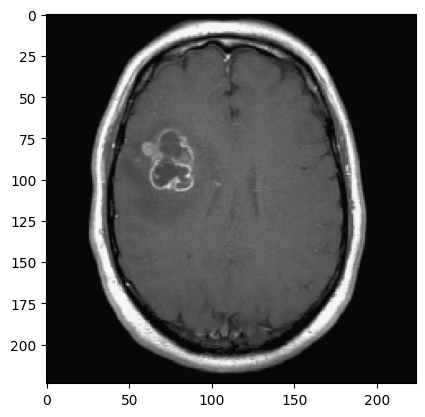

In [11]:
NUM = 14
plt.imshow(tf.keras.utils.array_to_img(images[NUM]))
print(labels[NUM], labels[NUM][1])
print(basic_results[NUM], np.argmax(basic_results[NUM]))
# A tumour should have a label of [0,1]
# We want a value of 1 for a tumour
# Therefore we should use teh second column, index 1

In [12]:
argmax_preds = [np.argmax(r) for r in basic_results] # 0 if no tumour, 1 if yes tumour
labels = [label[1] for label in y_test] # 0 if no tumour, 1 if yes tumour
acc = sklearn.metrics.accuracy_score(labels,argmax_preds)

In [13]:
initial_df = pd.DataFrame()
initial_df["class"] = labels # 0 if no tumour, 1 if there is a tumour
initial_df["image_index"] = [i for i in range(len(images))]
initial_df["confidence_class_0"] = [alpha[0] for alpha in basic_results]
initial_df["confidence_class_1"] = [alpha[1] for alpha in basic_results]

In [14]:
class_zero_df = initial_df[initial_df["class"] == 0] # no tumour
class_one_df = initial_df[initial_df["class"] == 1]
class_one_length = len(class_one_df)

In [15]:
print(class_one_length)

21


In [16]:
muba_df = pd.DataFrame(columns = [
                    "alpha_class_0",
                    "alpha_class_1",
                    "image",
                    "y_value_class_1",
    ])

In [17]:
# Iterate through NO tumour images
for index0, row0 in class_zero_df.iterrows():
    
    # Iterate through YES tumour images
    for index1, row1 in class_one_df.iterrows():

        for i in range(MUBA_ITERS):
            
            # Mixup images
            lam = (1/MUBA_ITERS) * np.random.rand() + ( (i) / MUBA_ITERS)
            new_img = lam * images[int(row0["image_index"])] + (1 - lam) * images[int(row1["image_index"])]

            row = { "alpha_class_0": lam, # row 0 is multiplied by lam
                    "alpha_class_1": 1-lam,
                    "image": new_img,
                    "y_value_class_1": (row1["confidence_class_1"] - row0["confidence_class_1"]) * (1-lam) + row0["confidence_class_1"], # Confidence in yes, there is a tumour
    
                    }
            
            muba_df = muba_df.append(row, ignore_index = True)


            




C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\3458984743.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = muba_df.append(row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\3458984743.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = muba_df.append(row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\3458984743.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df = muba_df.append(row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\3458984743.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  muba_df

In [18]:
initial_df

,class,image_index,confidence_class_0,confidence_class_1
0,0,0,0.190964,0.809036
1,0,1,0.482467,0.517533
2,1,2,0.217581,0.782419
3,0,3,0.713832,0.286168
4,1,4,0.236064,0.763936
5,1,5,0.135589,0.864411
6,1,6,0.101894,0.898106
7,1,7,0.488625,0.511375
8,0,8,0.633794,0.366206
9,0,9,0.202792,0.797208


In [19]:
#muba_df

(array([357., 358., 356., 357., 357., 357., 356., 357., 357., 358., 355.,
        357., 359., 357., 355., 354., 361., 357., 357., 358.]),
 array([4.31750289e-05, 5.00264322e-02, 1.00009689e-01, 1.49992947e-01,
        1.99976204e-01, 2.49959461e-01, 2.99942718e-01, 3.49925975e-01,
        3.99909233e-01, 4.49892490e-01, 4.99875747e-01, 5.49859004e-01,
        5.99842261e-01, 6.49825519e-01, 6.99808776e-01, 7.49792033e-01,
        7.99775290e-01, 8.49758547e-01, 8.99741805e-01, 9.49725062e-01,
        9.99708319e-01]),
 <BarContainer object of 20 artists>)

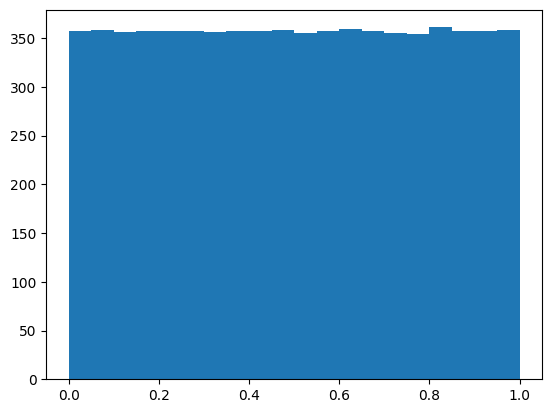

In [20]:
plt.hist(muba_df["alpha_class_1"], bins = 20)

In [21]:
# Get Predictions
result = model.predict(np.stack(muba_df["image"]))


224/224 [==============================] - 1211s 5s/step


In [22]:
pred_array = [np.argmax(individual_result) for individual_result in result] # 0 is no, 1 is yes

In [23]:
analysis_df = muba_df.drop('image',axis=1)

predictions = pd.DataFrame()
predictions["pred"] = pred_array

# Merge on predictions
analysis_df = analysis_df.join(predictions)
boundary_df = pd.DataFrame(columns = ["alpha","y"])

for i in range(int(len(analysis_df)/MUBA_ITERS)):
    # Create a mask to split df in to blocks of 20
    mask = (analysis_df.index >= MUBA_ITERS*i) & (analysis_df.index < MUBA_ITERS*i + MUBA_ITERS)
    window_df = analysis_df.loc[mask]

    # Find the index in which the prediction changes
    changing_pred_index = (window_df["pred"].diff()[window_df["pred"].diff() != 0].index.values)
    for boundary in changing_pred_index[1:]: # If pred doesn't change will equal 1
        row0 = window_df[window_df.index == boundary-1]
        row1 = window_df[window_df.index == boundary]
        middle_alpha = row0["alpha_class_1"][boundary-1] + ((row1["alpha_class_1"][boundary] - row0["alpha_class_1"][boundary-1]) / 2 )
        middle_y = row0["y_value_class_1"][boundary-1] + ( (row1["y_value_class_1"][boundary] - row0["y_value_class_1"][boundary-1]) / 2 )
        new_row = {
            "alpha":middle_alpha,
            "y":middle_y
        }
        
        boundary_df = boundary_df.append(new_row, ignore_index = True)

C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\1928143048.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundary_df = boundary_df.append(new_row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\1928143048.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundary_df = boundary_df.append(new_row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\1928143048.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  boundary_df = boundary_df.append(new_row, ignore_index = True)
C:\Users\Will Poulett\AppData\Local\Temp\ipykernel_30020\1928143048.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. 

In [24]:
correct_alphas = (analysis_df[analysis_df["pred"] == analysis_df["alpha_class_1"].round()])["alpha_class_1"]
incorrect_alphas = (analysis_df[analysis_df["pred"] != analysis_df["alpha_class_1"].round()])["alpha_class_1"]



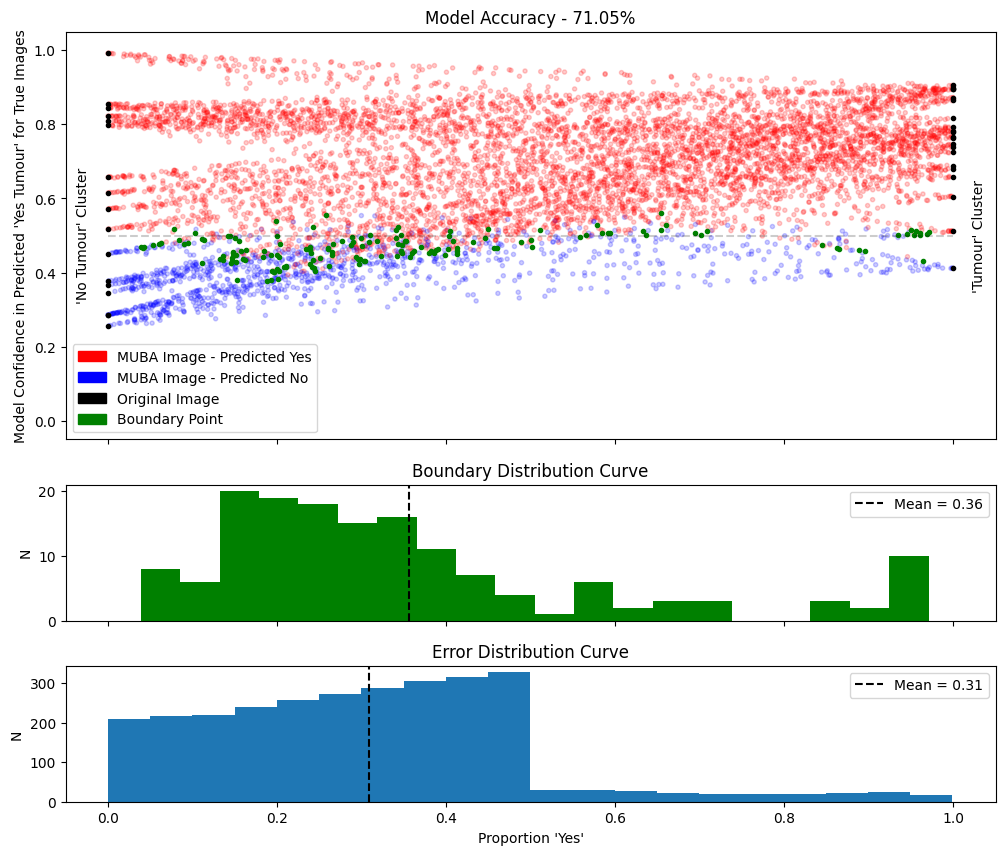

In [31]:
fig, ax = plt.subplots(3,1,gridspec_kw={'height_ratios': [3, 1,1]}, figsize = (12,10),sharex = True)
fig.subplots_adjust(hspace=0.2)

ax[0].plot([0,1],[0.5,0.5],color = "black", linestyle = "--",alpha=0.2)
ax[0].scatter(muba_df["alpha_class_1"],muba_df["y_value_class_1"], marker = ".", alpha = 0.2,color = ["red" if x == 1 else "blue" for x in predictions["pred"]], label = "Mixup Images")
ax[0].scatter(initial_df["class"],initial_df["confidence_class_1"], marker = ".", color = "black", label = "True Images")
ax[0].scatter(boundary_df["alpha"],boundary_df["y"], marker = ".", color = "green")
ax[0].set_ylim([-0.05,1.05])

# Create a legend with a color box
no_patch = mpatches.Patch(color='red', label='MUBA Image - Predicted Yes')
yes_patch = mpatches.Patch(color='blue', label='MUBA Image - Predicted No')
original_patch = mpatches.Patch(color='black', label='Original Image')
middle_patch = mpatches.Patch(color='green', label='Boundary Point')

ax[0].legend(handles=[no_patch, yes_patch, original_patch, middle_patch])
ax[0].set_ylabel("Model Confidence in Predicted 'Yes Tumour' for True Images")
ax[0].text(-0.03,0.5,"'No Tumour' Cluster", rotation = "vertical", va = "center", ha = "center")
ax[0].text(1.03,0.5,"'Tumour' Cluster", rotation = "vertical", va = "center", ha = "center")
ax[0].set_title(f"Model Accuracy - {round(100*acc,2)}%")

# ax.axis("off")
ax[1].hist(boundary_df["alpha"],bins=20,color="green")
mean = np.mean(boundary_df["alpha"])
ax[1].axvline(mean, color = "black", linestyle = "--", label = f"Mean = {round(mean,2)}")
ax[1].set_ylabel("N")
ax[1].set_title("Boundary Distribution Curve")
ax[1].legend()

ax[2].hist(incorrect_alphas,bins=20)
mean = np.mean(incorrect_alphas)
ax[2].axvline(mean, color = "black", linestyle = "--", label = f"Mean = {round(mean,2)}")
ax[2].set_xlabel("Proportion 'Yes'")
ax[2].set_ylabel("N")
ax[2].set_title("Error Distribution Curve")
ax[2].legend()